In [801]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, is_outlier

### Read in clean .CSV data

In [802]:
house_train = pd.read_csv('../datasets/house_train_clean.csv')

### Make DataFrames wide

In [803]:
pd.set_option('display.max_columns', 100)

Modify ORDINAL, NOMINAL, CONTINUOUS and DISCRETE variables based on whatever info we've dropped or kept from the first notebook

In [804]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

# Remove Price Outliers from Target based on Z-Score

In [805]:
# remove saleprice outliers 
house_train = house_train[~is_outlier(house_train.saleprice)];

c:\Users\alexs\Documents\dsir-1031\projects\project_2\code\cleaning_script.py:57: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


# Plot saleprice with Outliers Removed

<AxesSubplot:ylabel='Frequency'>

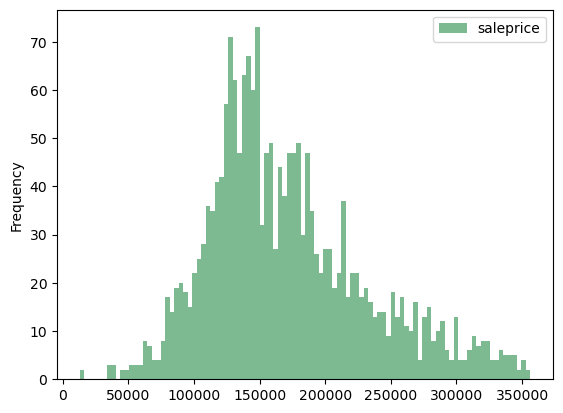

In [806]:
house_train.plot.hist(y='saleprice', bins=100)

# Look for Correlations within Numerical Categories

In [807]:
# create helper function for plotting correlations
corr_vals = {}
def plot_corr_heatmap(CATEGORY, title):
    COLUMNS = [x for x in CATEGORY]
    COLUMNS.append('saleprice')

    fig, ax = plt.subplots(figsize=(12,12))
    corr = house_train[COLUMNS].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.title(f'{title} Correlations')
    return sns.heatmap(corr, mask=mask, annot=True), corr['saleprice']

# dictionary of correlative factors
correlative_factors = {}

### Discrete

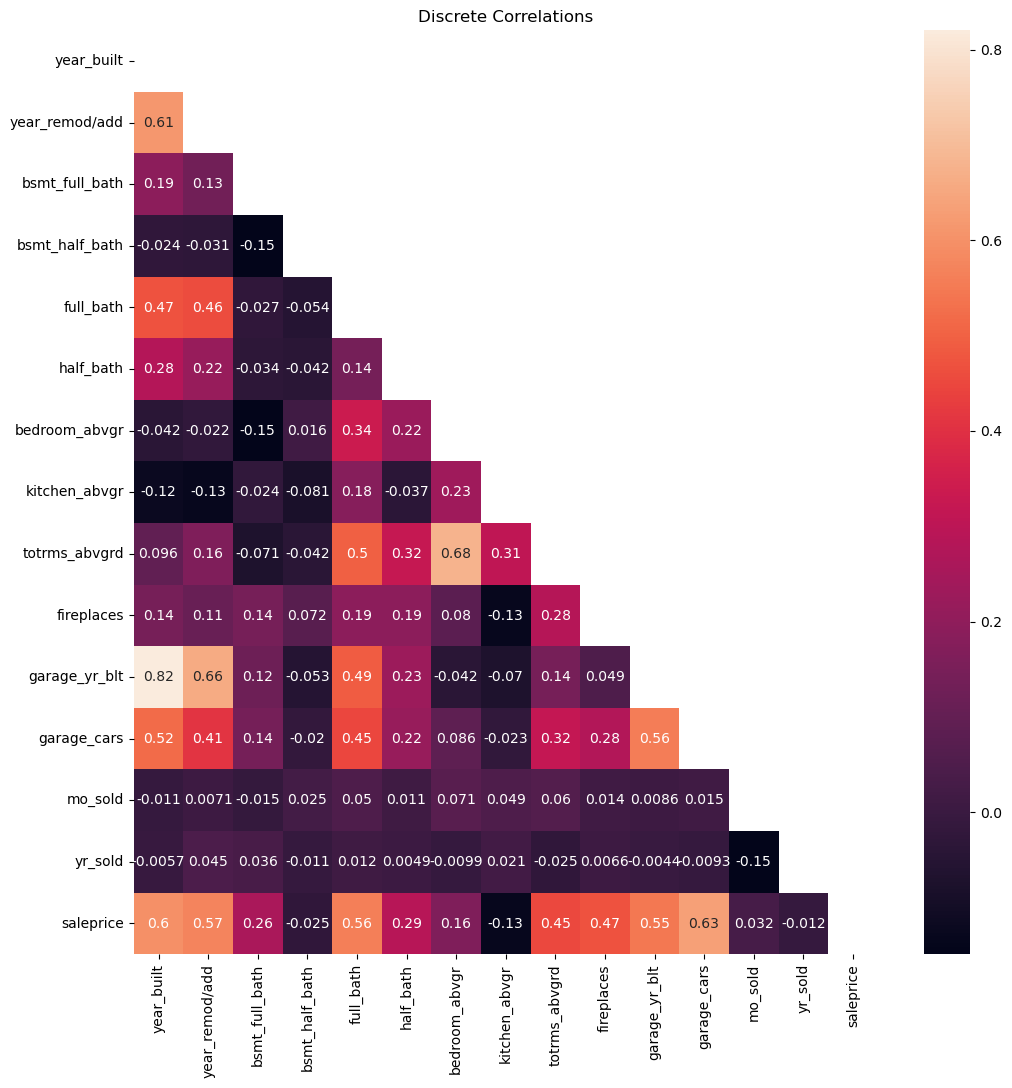

In [808]:
discrete_corrs = plot_corr_heatmap(DISCRETE, 'Discrete')

correlative_factors.update(discrete_corrs[1].to_dict())

### Continous

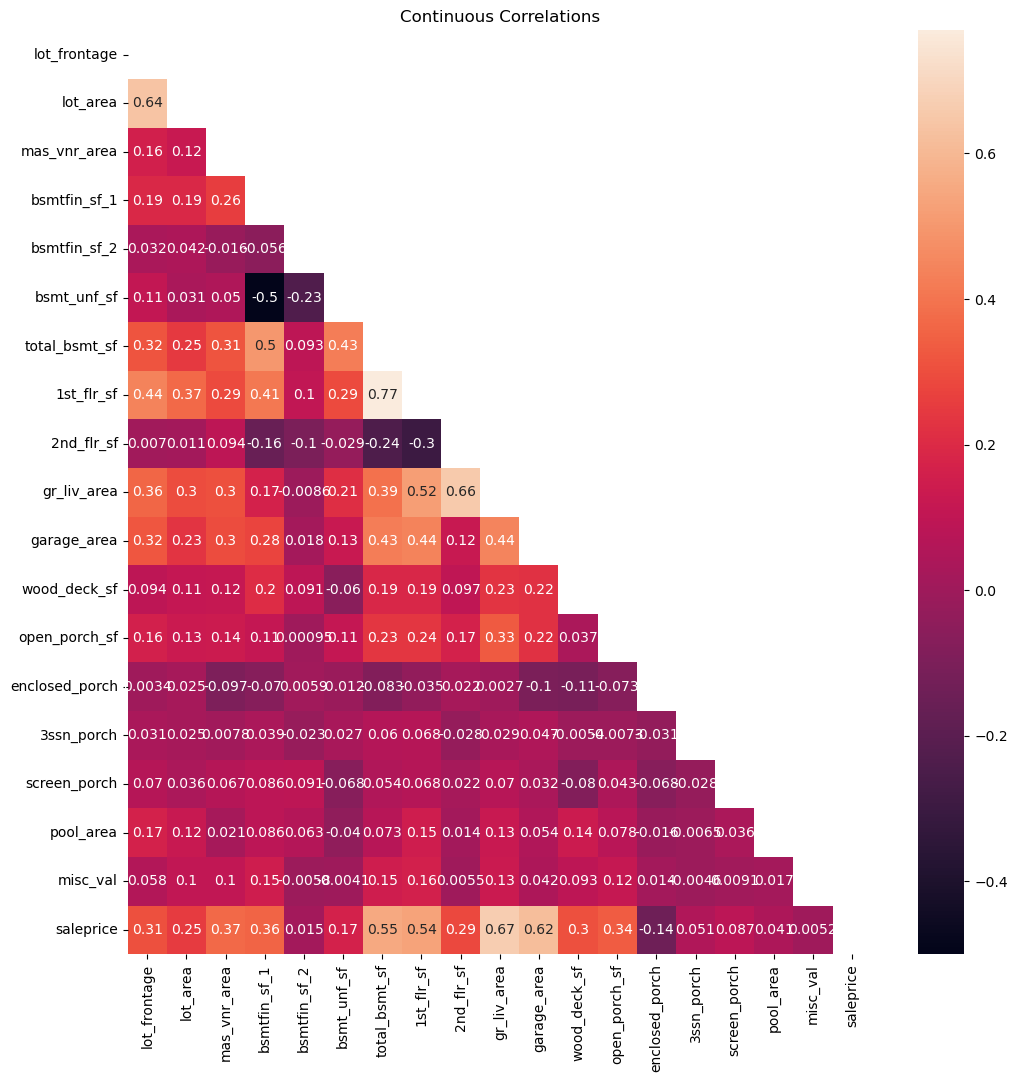

In [809]:
continuous_corrs = plot_corr_heatmap(CONTINUOUS, 'Continuous')

correlative_factors.update(continuous_corrs[1].to_dict())

### Ordinal

Theres clearly a lot of value in these ranked qualitative values, we'll make them numeric and see if we can get some more value. 

       
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

The following columns use this system:  
- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

In [810]:
# function to rank Ordinal quality ratings
def ordinal_to_numeric(val):
    if val == 'Ex':
        return 4
    elif val == 'Gd':
        return 3
    elif val == 'TA':
        return 2
    elif val == 'Fa':
        return 1
    elif val == 'Po':
        return 0
    else:
        pass

Find the columns that use the 'Ex - Po' rating schema

In [811]:
rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
rank_words = pd.Series(rank_words)
columns_to_fix = []

# find columns, append to columns to fix
for col in house_train[ORDINAL].columns:
    word_check = rank_words.isin(house_train[ORDINAL][col])
    if word_check.sum() > 0:
        columns_to_fix.append(col)
        
# convert columns to numeric values
for col in columns_to_fix:
    house_train[col] = [ordinal_to_numeric(val) for val in house_train[col]]

Ordinal Correlations

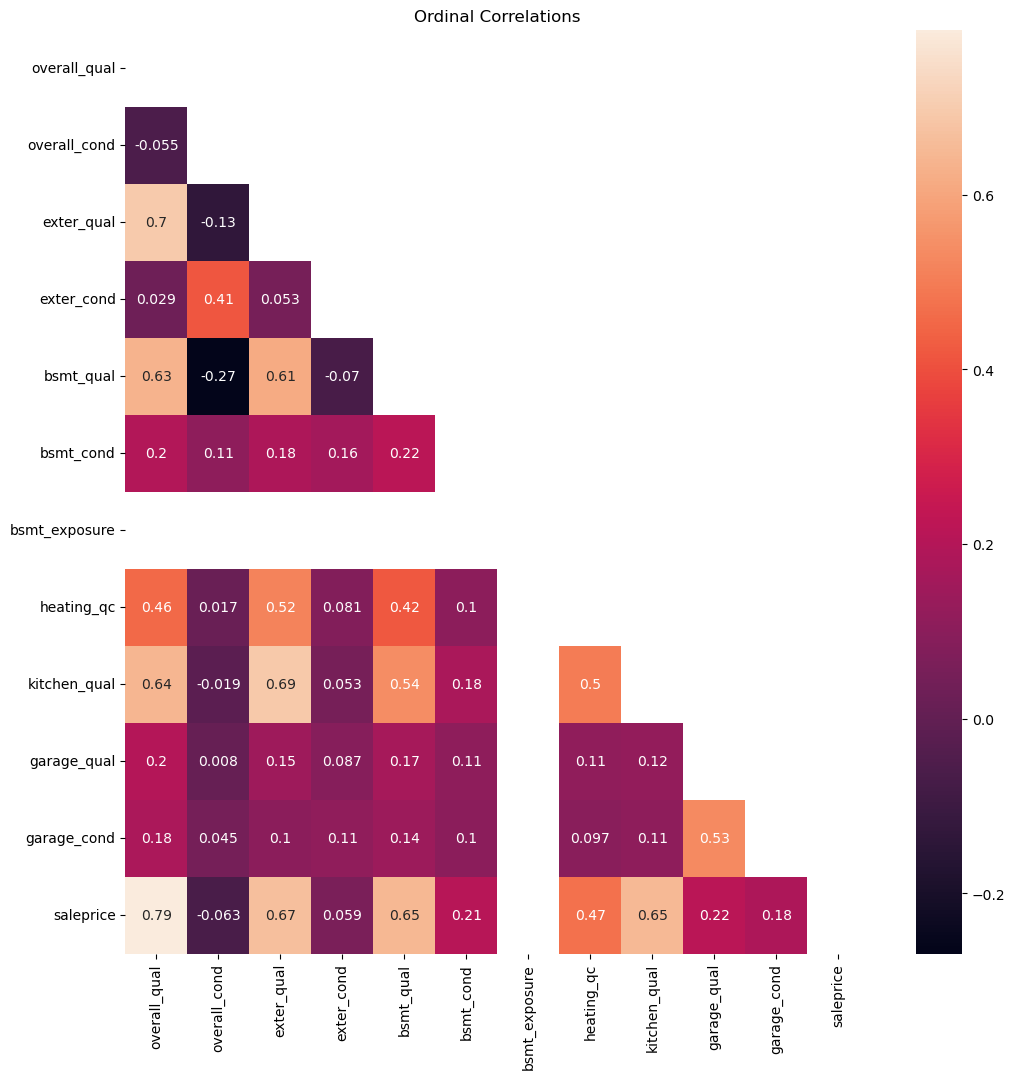

In [812]:
ordinal_corrs = plot_corr_heatmap(ORDINAL, 'Ordinal')

correlative_factors.update(ordinal_corrs[1].to_dict())

### Nominal

Condition 1 (Nominal): Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

These seem important! location, location, location. Let's make them numerical too. 

In [813]:
# get dummies and concat
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

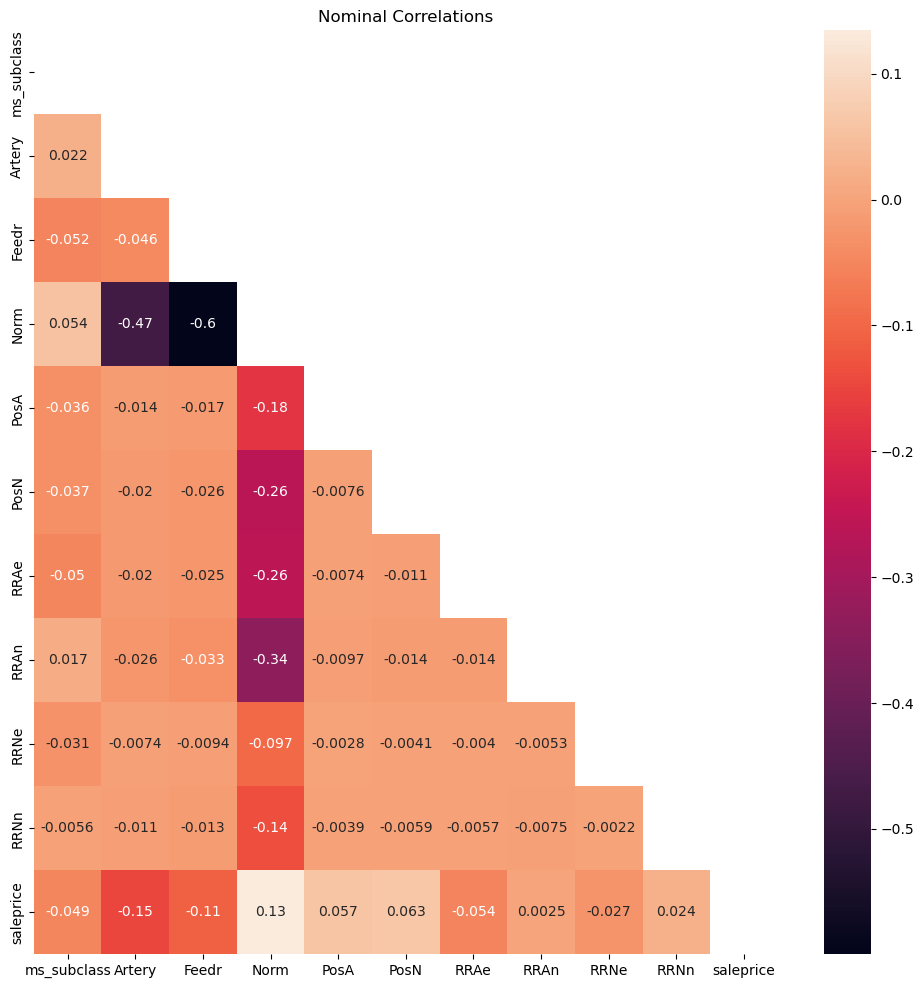

In [814]:
nominal_corrs = plot_corr_heatmap(NOMINAL, 'Nominal')

correlative_factors.update(nominal_corrs[1].to_dict())

'Norm' 'PosA' and 'PosN' have a weak positive correlative effect and being near a railroad or busy thruway has a weak negative correlative effect

# Find Most Correlative Factors
- Gives us a place to start building new features from

In [815]:
correlative_factors = {k:v for k,v in correlative_factors.items() if abs(v) > .5}

correlative_factors

{'year_built': 0.600319421039662,
 'year_remod/add': 0.571962989809752,
 'full_bath': 0.5601246780482705,
 'garage_yr_blt': 0.5459818233134736,
 'garage_cars': 0.6319768963684793,
 'saleprice': 1.0,
 'total_bsmt_sf': 0.551055118239924,
 '1st_flr_sf': 0.5351632174227725,
 'gr_liv_area': 0.6662364461377922,
 'garage_area': 0.6180236553188305,
 'overall_qual': 0.7889826572391594,
 'exter_qual': 0.6668752258698762,
 'bsmt_qual': 0.6470941635516447,
 'kitchen_qual': 0.6522624366139739}

# Feature Engineering

### Neighborhood Group

In [816]:
group_by_neighborhood = house_train.groupby('neighborhood')['saleprice'].median().sort_values(ascending=False)

neighbor_hood_dict = {}
for i, val in enumerate(group_by_neighborhood):
    neighbor_hood_dict.update({group_by_neighborhood.index[i]:i})

house_train['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_train.neighborhood]

In [817]:
# .73, nice!
neighborhood_corr = house_train[['neighborhood_price_rank', 'saleprice']].corr()

correlative_factors.update(neighborhood_corr['saleprice'].to_dict())

### Age of Home

In [818]:
house_train['age'] = house_train['yr_sold'] - house_train['year_built']

In [819]:
# .60
age_corr = house_train[['age', 'saleprice']].corr()

correlative_factors.update(age_corr['saleprice'].to_dict())

### Missing Values for Correlative Factors

In [820]:
missing = house_train[correlative_factors.keys()].isnull().sum()

missing

year_built                   0
year_remod/add               0
full_bath                    0
garage_yr_blt              114
garage_cars                  1
saleprice                    0
total_bsmt_sf                1
1st_flr_sf                   0
gr_liv_area                  0
garage_area                  1
overall_qual                 0
exter_qual                   0
bsmt_qual                   55
kitchen_qual                 0
neighborhood_price_rank      0
age                          0
dtype: int64

In [821]:
for col in house_train[correlative_factors.keys()].columns:
    house_train[col].fillna(house_train[col].median(), inplace=True)

Sanity check
- quick LinReg to see how we're moving along

In [852]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score

X = house_train[[x for x in correlative_factors.keys() if x not in ['saleprice']]]
y = house_train.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, y)


X_train.isnull().sum()

mlr = LinearRegression()

X_train.isnull().sum()
scores_1 = (cross_val_score(LinearRegression(), X_train, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=73)))

scores_1.mean()



0.8577077003830962